## Dogs: loglinear model for binary data

    Following is Bayesian modelling of Lindley's analysis of dogs data from Solomon-Wynne experiment in Pyro.
    The experiment intended to study the learning hailing from past traumatic experiences in dogs and reach a plausible model where dogs learn to avoid the scenerios responsible for causing trauma in past (Here, avoiding jumping off the barriers loaded with electric shocks).


    Following analysis uses a model `πj   =   Axj Bj-xj` wherein dog learns from previous trials.
    Here `πj`, the probability of a shock at trial `j` depends on the number of previous shocks and the number of previous avoidances by the dog.

In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import pyro
from scipy import stats
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule
from pyro.infer import MCMC, NUTS

import random
import numpy as np
import time
import random
import pandas as pd
from collections import defaultdict
import plotly.express as px
import re
import itertools

pyro.set_rng_seed(1)

# Uncomment following if pandas available with plotly backend

# pd.options.plotting.backend = "plotly"

%matplotlib inline
plt.style.use('default')

### Dogs Model definition
________
  
  **BUGS model**
  
      log πj = α xj + β ( j-xj )

   **Here**
   * `log πj` is log probability of a dog getting shocked at trial `j`
   * `xj` is number of successful avoidances of shock prior to trial `j`.
    * `j- xj` is number of shocks experienced prior to trial `j`.
   *  `α` is the coefficient corresponding to number of success, `β` is the coefficient corresponding to number of failures.

  
  ____________________
  
  **Equivalent Stan model** 
  
      {
  
      alpha ~ normal(0.0, 316.2);
  
      beta  ~ normal(0.0, 316.2);
  
      for(dog in 1:Ndogs)
  
        for (trial in 2:Ntrials)  

          y[dog, trial] ~ bernoulli(exp(alpha * xa[dog, trial] + beta * 
          xs[dog, trial]));
      
      }  


In [2]:
def DogsModel(x_avoidance, x_shocked, y):
    """
      model {
      alpha ~ normal(0.0, 316.2);
      beta  ~ normal(0.0, 316.2);
      for(dog in 1:Ndogs)  
        for (trial in 2:Ntrials)  
          y[dog, trial] ~ bernoulli(exp(alpha * xa[dog, trial] + beta * xs[dog, trial]));
    """
    alpha = pyro.sample("alpha", dist.Normal(0., 316.))
    beta = pyro.sample("beta", dist.Normal(0., 316))
    with pyro.plate("data"):
        pyro.sample("obs", dist.Bernoulli(torch.exp(alpha*x_avoidance + beta * x_shocked)), obs=y)


**Following processes target label `y` to obtain input data `x_avoidance` & `x_shocked` where:**
* `x_avoidance` :  number of shock avoidances before current trial.
* `x_shocked` :  number of shocks before current trial.

In [3]:
def transform_data(Ndogs=30, Ntrials=25, Y= np.array([0, 0, 0, 0])):
    y= np.zeros((Ndogs, Ntrials))
    xa= np.zeros((Ndogs, Ntrials))
    xs= np.zeros((Ndogs, Ntrials))

    for dog in range(1, Ndogs):
        for trial in range(2, Ntrials):
            for k in range(1, trial-1):
                xa[dog,trial]=xa[dog,trial] + Y[dog, k]
            xs[dog,trial]=trial -1 - xa[dog,trial]
    for dog in range(1, Ndogs):
        for trial in range(1, Ntrials):
            y[dog, trial]= 1- Y[dog, trial]
    xa= torch.tensor(xa, dtype=torch.float)
    xs= torch.tensor(xs, dtype=torch.float)  
    y= torch.tensor(y, dtype=torch.float)
    
    return xa, xs, y

In [4]:
dogs_data = {"Ndogs":30, 
             "Ntrials":25, 
             "Y": np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                  0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
                  0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 
                  1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 
                  1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 
                  0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 
                  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 
                  1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]).reshape((30,25))}

In [5]:
x_avoidance, x_shocked, y= transform_data(**dogs_data)
print("x_avoidance: %s, x_shocked: %s, y: %s"%(x_avoidance.shape, x_shocked.shape, y.shape))

x_avoidance: torch.Size([30, 25]), x_shocked: torch.Size([30, 25]), y: torch.Size([30, 25])


In [6]:
def get_hmc_n_chains(pyromodel, xa, xs, y, num_chains=4, base_count = 900):
    hmc_sample_chains =defaultdict(dict)
    possible_samples_list= random.sample(list(np.arange(base_count, base_count+num_chains*100, 50)), num_chains)
    possible_burnin_list= random.sample(list(np.arange(100, 500, 50)), num_chains)

    t1= time.time()
    for idx, val in enumerate(list(zip(possible_samples_list, possible_burnin_list))):
        num_samples, burnin= val[0], val[1]
        nuts_kernel = NUTS(pyromodel)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=burnin)
        mcmc.run(xa, xs, y)
        hmc_sample_chains['chain_{}'.format(idx)]={k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    print("\nTotal time: ", time.time()-t1)
    hmc_sample_chains= dict(hmc_sample_chains)
    return hmc_sample_chains

In [7]:
hmc_sample_chains= get_hmc_n_chains(DogsModel,x_avoidance, x_shocked, y, num_chains=4, base_count = 900)

Sample: 100%|██████████| 1600/1600 [00:06, 264.65it/s, step size=5.90e-01, acc. prob=0.908]


Total time:  35.99129509925842


**Parameter vs. Chain matrix**

In [8]:
beta_chain_matrix_df = pd.DataFrame(hmc_sample_chains)
# beta_chain_matrix_df.to_csv("stack_regression_hmc_sample_chains.csv", index=False)
beta_chain_matrix_df

,chain_0,chain_1,chain_2,chain_3
alpha,"[-0.19940403, -0.19707194, -0.19592816, -0.179...","[-0.18621065, -0.21473865, -0.21353526, -0.190...","[-0.18898056, -0.19668622, -0.21569654, -0.182...","[-0.20917203, -0.21078308, -0.21078308, -0.209..."
beta,"[-0.056416504, -0.035576165, -0.033310093, -0....","[-0.043880932, -0.02577101, -0.031183429, -0.0...","[-0.035699867, -0.037233904, -0.034914747, -0....","[-0.027547669, -0.025921483, -0.025921483, -0...."


**Key statistic results as dataframe**

In [9]:
all_metric_func_map = lambda metric, vals: {"mean":np.mean(vals), "std":np.std(vals), 
                                            "25%":np.quantile(vals, 0.25), 
                                            "50%":np.quantile(vals, 0.50), 
                                            "75%":np.quantile(vals, 0.75)}.get(metric)

In [10]:
key_metrics= ["mean", "std", "25%", "50%", "75%"]

summary_stats_df_= pd.DataFrame()
for metric in key_metrics:
    final_di = {}
    for column in beta_chain_matrix_df.columns:
        params_per_column_di = dict(beta_chain_matrix_df[column].apply(lambda x: all_metric_func_map(metric, x)))
        final_di[column]= params_per_column_di
    metric_df_= pd.DataFrame(final_di)
    metric_df_["parameter"]= metric
    summary_stats_df_= pd.concat([summary_stats_df_, metric_df_], axis=0)

summary_stats_df_.reset_index(inplace=True)
summary_stats_df_.rename(columns= {"index":"metric"}, inplace=True)
summary_stats_df_.set_index(["parameter", "metric"], inplace=True)
summary_stats_df_

chain_0   chain_1   chain_2   chain_3
parameter metric                                        
mean      alpha  -0.193815 -0.193025 -0.194037 -0.193621
          beta   -0.035932 -0.036215 -0.035930 -0.035987
std       alpha   0.012070  0.011836  0.012916  0.012475
          beta    0.005856  0.006262  0.006242  0.005867
25%       alpha  -0.202422 -0.200603 -0.202577 -0.201943
          beta   -0.039491 -0.040492 -0.040681 -0.040008
50%       alpha  -0.193324 -0.192924 -0.192871 -0.193799
          beta   -0.035578 -0.035981 -0.035805 -0.035531
75%       alpha  -0.185350 -0.184732 -0.185084 -0.185419
          beta   -0.031821 -0.031842 -0.030871 -0.032071

**Obtain 5 point Summary statics (mean, Q1-Q4, Std, ) as tabular data per chain.**


In [17]:
fit_df = pd.DataFrame()
for chain, values in hmc_sample_chains.items():
    param_df = pd.DataFrame(values)
    param_df["chain"]= chain
    fit_df= pd.concat([fit_df, param_df], axis=0)

fit_df.to_csv("data/dogs_classification_hmc_samples.csv", index=False)    
fit_df

,alpha,beta,chain
0,-0.199404,-0.056417,chain_0
1,-0.197072,-0.035576,chain_0
2,-0.195928,-0.033310,chain_0
3,-0.179669,-0.039480,chain_0
4,-0.185855,-0.037525,chain_0
...,...,...,...
1245,-0.193644,-0.036158,chain_3
1246,-0.182684,-0.038603,chain_3
1247,-0.178999,-0.045139,chain_3
1248,-0.201096,-0.030563,chain_3


In [18]:
# Use following once the results from pyro sampling operation are saved offline

# fit_df= pd.read_csv("data/dogs_classification_hmc_samples.csv")
# fit_df

,alpha,beta,chain
0,-0.199404,-0.056417,chain_0
1,-0.197072,-0.035576,chain_0
2,-0.195928,-0.033310,chain_0
3,-0.179669,-0.039480,chain_0
4,-0.185855,-0.037525,chain_0
...,...,...,...
1245,-0.193644,-0.036158,chain_3
1246,-0.182684,-0.038603,chain_3
1247,-0.178999,-0.045139,chain_3
1248,-0.201096,-0.030563,chain_3


In [20]:
summary_stats_df_2= pd.DataFrame()

for param in ["alpha", "beta"]:
    for name, groupdf in fit_df.groupby("chain"):
        groupdi = dict(groupdf[param].describe())

        values = dict(map(lambda key:(key, [groupdi.get(key)]), ['mean', 'std', '25%', '50%', '75%']))
        values.update({"parameter": param, "chain":name})
        summary_stats_df= pd.DataFrame(values)
        summary_stats_df_2= pd.concat([summary_stats_df_2, summary_stats_df], axis=0)
summary_stats_df_2.set_index(["parameter", "chain"], inplace=True)
summary_stats_df_2

mean       std       25%       50%       75%
parameter chain                                                    
alpha     chain_0 -0.193815  0.012076 -0.202422 -0.193324 -0.185350
          chain_1 -0.193025  0.011841 -0.200603 -0.192924 -0.184732
          chain_2 -0.194037  0.012923 -0.202577 -0.192871 -0.185084
          chain_3 -0.193621  0.012480 -0.201943 -0.193799 -0.185419
beta      chain_0 -0.035932  0.005858 -0.039491 -0.035578 -0.031821
          chain_1 -0.036215  0.006265 -0.040492 -0.035981 -0.031842
          chain_2 -0.035930  0.006245 -0.040681 -0.035805 -0.030871
          chain_3 -0.035987  0.005870 -0.040008 -0.035531 -0.032071

**Following Plots m parameters side by side for n chains**

In [21]:
parameters= ["alpha", "beta"]# All parameters for given model
chains= fit_df["chain"].unique()# Number of chains sampled for given model


func_all_params_per_chain = lambda param, chain: (param, fit_df[fit_df["chain"]==chain][param].tolist())
func_all_chains_per_param = lambda chain, param: (f'{chain}', fit_df[param][fit_df["chain"]==chain].tolist())

di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain(param, "chain_0"), parameters))
di_all_chains_per_param = dict(map(lambda chain: func_all_chains_per_param(chain, "beta"), chains))

In [22]:
def plot_parameters_for_n_chains(chains=["chain_0"], parameters=["beta0", "beta1", "beta2", "beta3", "sigma"], plotting_cap=[4, 5], plot_interactive=False):
    try:
        chain_cap, param_cap = plotting_cap#
        assert len(chains)<=chain_cap, "Cannot plot Number of chains greater than %s!"%chain_cap
        assert len(parameters)<=param_cap, "Cannot plot Number of parameters greater than %s!"%param_cap
        
        for chain in chains:
            di_all_params_per_chain = dict(map(lambda param: func_all_params_per_chain(param, chain), parameters))
            df_all_params_per_chain = pd.DataFrame(di_all_params_per_chain)
            if df_all_params_per_chain.empty:
#                 raise Exception("Invalid chain number in context of model!")
                print("Note: Chain number [%s] is Invalid in context of this model!"%chain)
                continue
            if plot_interactive:
                df_all_params_per_chain= df_all_params_per_chain.unstack().reset_index(level=0)
                df_all_params_per_chain.rename(columns={"level_0":"parameters", 0:"values"}, inplace=True)
                fig = px.box(df_all_params_per_chain, x="parameters", y="values")
                fig.update_layout(height=600, width=900, title_text=f'{chain}')
                fig.show()
            else:
                df_all_params_per_chain.plot.box()
                plt.title(f'{chain}')
    except Exception as error:
        if type(error) is AssertionError:
            print("Note: %s"%error)
            chains = np.random.choice(chains, chain_cap, replace=False)
            parameters=np.random.choice(parameters, param_cap, replace=False)
            plot_parameters_for_n_chains(chains, parameters)
        else: print("Error: %s"%error)


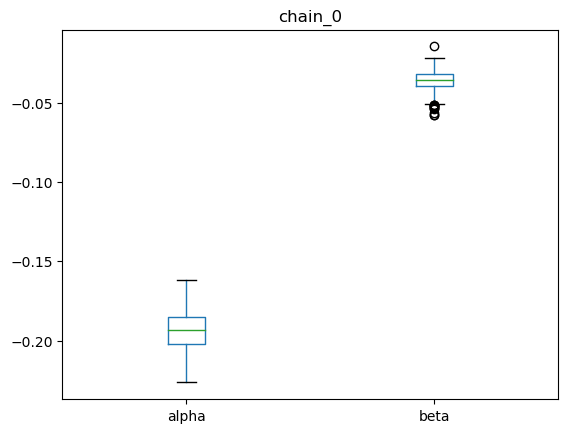

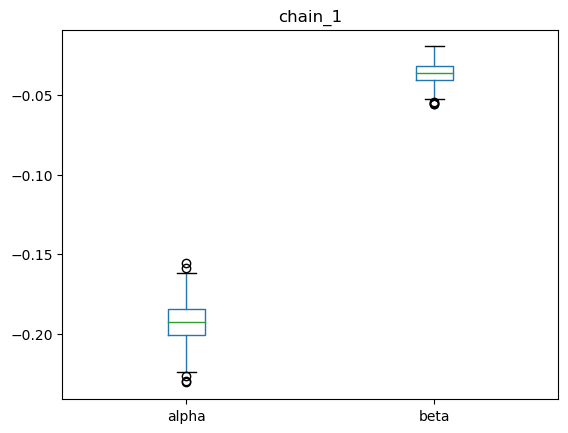

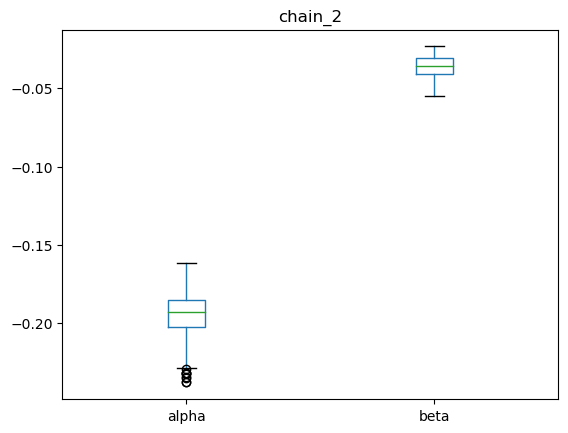

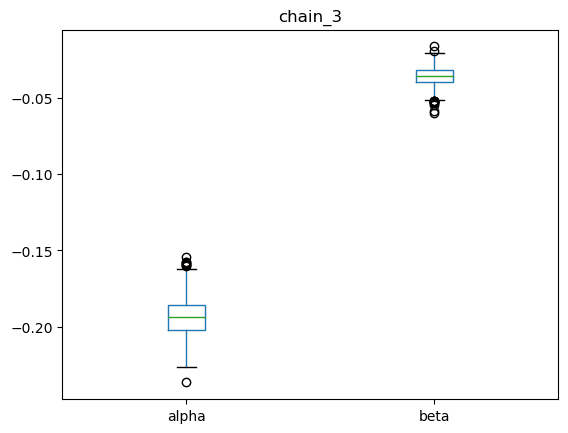

In [23]:
# Use plot_interactive=True for plotly plots offline

plot_parameters_for_n_chains(chains=['chain_0', 'chain_1', 'chain_2', 'chain_3'], parameters=parameters, plot_interactive=False)


**Joint distribution of pair of each parameter sampled values**


Pyro -- alpha Vs. beta


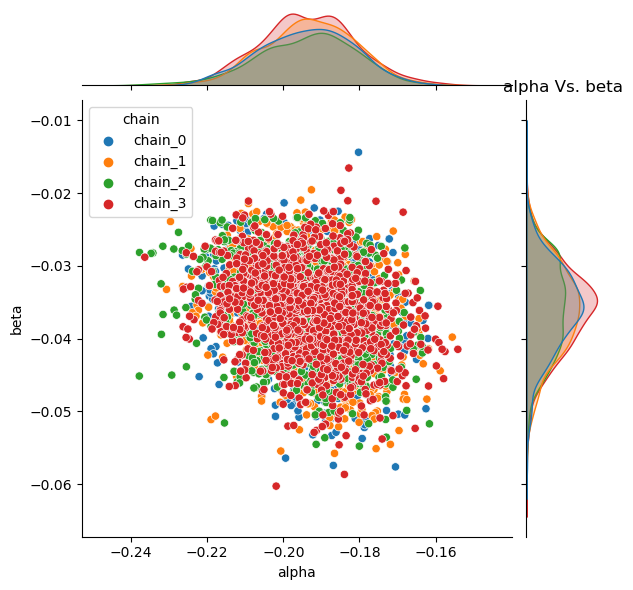

In [24]:
all_combination_params = list(itertools.combinations(parameters, 2))

for param_combo in all_combination_params:
    param1, param2= param_combo
    print("\nPyro -- %s"%(f'{param1} Vs. {param2}'))
    sns.jointplot(data=fit_df, x=param1, y=param2, hue= "chain")
    plt.title(f'{param1} Vs. {param2}')
    plt.show()
    

**Pairplot distribution of each parameter with every other parameter's sampled values**

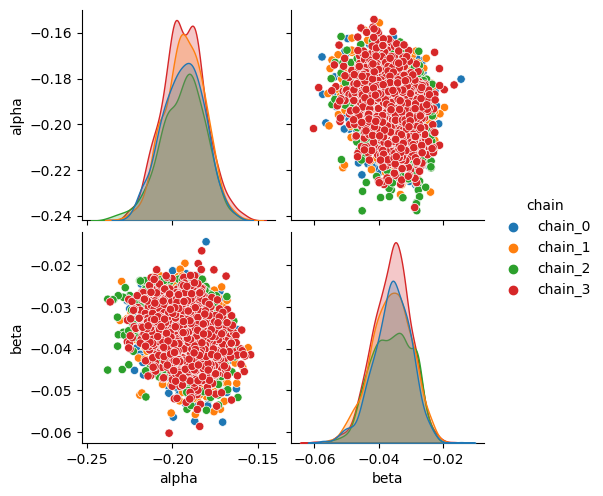

In [25]:
sns.pairplot(data=fit_df, hue= "chain");

**Hexbin plots**

In [26]:
import matplotlib.pyplot as plt
import re
import itertools

%matplotlib inline 
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=1, cmap=plt.cm.Reds)
    cb = fig.colorbar(hbin, ax=ax)
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
# hexbin_plot(difficulty_df_a['difficulty_keras'], difficulty_df_a['calibrated_difficulty'], "IRT difficulty for ch-a", "calibrated difficulty for ch-a")  

In [27]:
fit_df

,alpha,beta,chain
0,-0.199404,-0.056417,chain_0
1,-0.197072,-0.035576,chain_0
2,-0.195928,-0.033310,chain_0
3,-0.179669,-0.039480,chain_0
4,-0.185855,-0.037525,chain_0
...,...,...,...
1245,-0.193644,-0.036158,chain_3
1246,-0.182684,-0.038603,chain_3
1247,-0.178999,-0.045139,chain_3
1248,-0.201096,-0.030563,chain_3


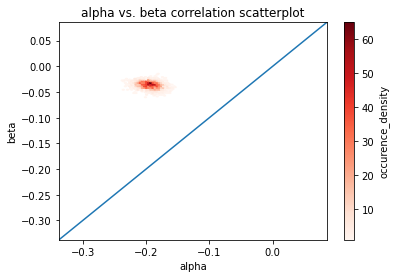

In [28]:
def plot_interaction_hexbins(fit_df, parameters=["beta0", "beta1", "beta2", "beta3", "sigma"]):
    all_combination_params = list(itertools.combinations(parameters, 2))
    for param1, param2 in all_combination_params:#Plots interaction between each of two parameters
        hexbin_plot(fit_df[param1], fit_df[param2], param1, param2)
        
plot_interaction_hexbins(fit_df, parameters=parameters)

**Loading Pystan model**

**Pystan model for model comparison [For now Ignore]**

In [30]:
import pystan as ps
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
# pd.options.plotting.backend = "plotly"



dogs_code = """
data {
  int<lower=0> Ndogs; 
  int<lower=0> Ntrials; 
  int Y[Ndogs, Ntrials];
}
transformed data {
  int y[Ndogs, Ntrials];
  int xa[Ndogs, Ntrials]; 
  int xs[Ndogs, Ntrials];
  for (dog in 1:Ndogs) {
    xa[dog, 1] <- 0; 
    xs[dog, 1] <- 0;
    for (trial in 2:Ntrials) {
      for (k in 1:(trial - 1))
        xa[dog, trial] <- xa[dog, trial] + Y[dog, k]; 
      xs[dog, trial] <- trial - 1 - xa[dog, trial];
    }
  }
  for (dog in 1:Ndogs) {
    for (trial in 1:Ntrials) {
      y[dog, trial] <- 1 - Y[dog, trial];
    }
  }
} 
parameters {
  real<upper= -0.00001> alpha;
  real<upper= -0.00001> beta;
} 
model {
  alpha ~ normal(0.0, 316.2);
  beta  ~ normal(0.0, 316.2);
  for(dog in 1:Ndogs)  
    for (trial in 2:Ntrials)  
      y[dog, trial] ~ bernoulli(exp(alpha * xa[dog, trial] + beta * xs[dog, trial]));
} 
generated quantities {
  real A;
  real B;
  A <- exp(alpha);
  B <- exp(beta);
}
"""

# dogs_data

In [31]:
# posterior = ps.StanModel(model_code=dogs_code)
# fit = posterior.sampling(data=dogs_data, iter=1000, chains=4, seed=1)

**Obtain 5 point Summary statics (mean, Q1-Q4, Std, ) as tabular data per chain.**


In [32]:
# fit_df_pystan= fit.to_dataframe()

# summary_stats_df_pystan= pd.DataFrame()

# for param in ["alpha", "beta"]:
#     for name, groupdf in fit_df_pystan.groupby("chain"):
#         groupdi = dict(groupdf[param].describe())
        
#         values = dict(map(lambda key:(key, [groupdi.get(key)]), ['mean', 'std', '25%', '50%', '75%']))
#         values.update({"parameter": param, "chain":name})
#         summary_stats_df= pd.DataFrame(values)
#         summary_stats_df_pystan= pd.concat([summary_stats_df_pystan, summary_stats_df], axis=0)
# summary_stats_df_pystan.set_index(["parameter", "chain"], inplace=True)
# summary_stats_df_pystan

_______________